In [1]:
###########################################################
# MSDS 442: AI Agent Design and Development
# Spring '25
# Dr. Bader
#
# Assignment 3 - Allstate Insurance Policy & Claims Agent
# 
# Kevin Geidel
#
###########################################################

# OBJECTIVE:
#   The following will construct an AI agent using the LangChain & LangGraph frameworks. 
#   The agent will consist of multiple nodes that coordinate to process insurance claims.

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Python native imports
import os, sys, re, base64, datetime, operator, random

# Third party library import
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
os.environ['USER_AGENT'] = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
__import__('pysqlite3')
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_core.messages import SystemMessage, HumanMessage
import fitz, io
from PIL import Image as PilImage
from IPython.display import Image, display, Markdown

# Assign experiment-wide variables
model_name = 'gpt-4o-mini'
data_dir = os.path.join('Assignment_3')

In [2]:
# Establish some utils for working with langgraph
def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = PilImage.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

In [3]:
# Establish functions used by agents

def verify_policy(state) -> Literal["damage_assessment_agent", "claim_denied"]:   
    # extract the policy number w/ regex
    claim_submitted = state["claim_submitted"]

    check_claim_str = str(claim_submitted[0])

    policy_number_submitted = re.search(r"Policy number:\s*([\d\s]+)", check_claim_str)
    
    if policy_number_submitted:
        policy_number = policy_number_submitted.group(1).strip()
    else:
        return "claim_denied" # (must submit policy number!)

    # direct to nodes based on deliquency status
    if state['delinquency_policyholder_status'] == "Policyholder 90-Days Delinquent" :
        return "claim_denied"
    if policy_number == state["policy_number_on_record"]:
        return "damage_assessment_agent"    
    return "claim_denied"

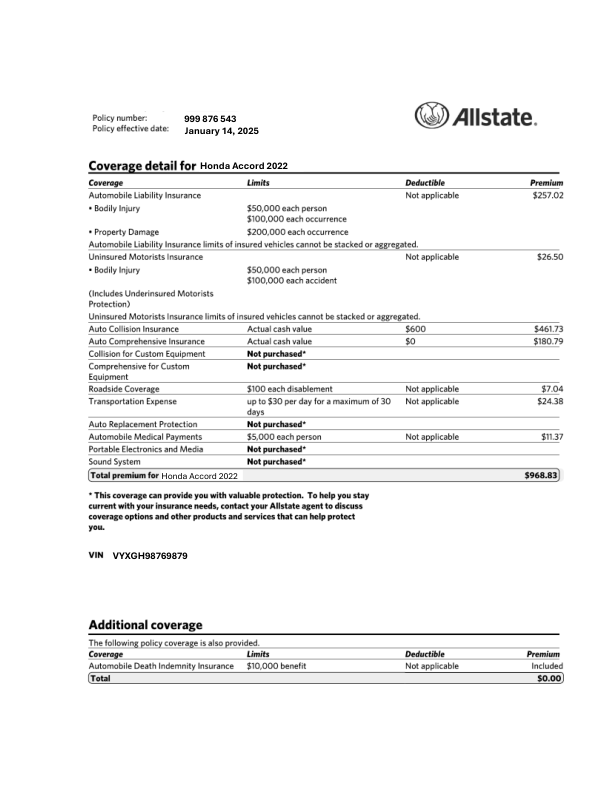

In [4]:
# Load a customer policy

vehicle_insurance_file_path = os.path.join(
    data_dir, 'Allstate_honda_vehicle_insurance.pdf'
)
policy_base64_image = pdf_page_to_base64(vehicle_insurance_file_path,1)

from IPython.display import Image as IPImage
display(IPImage(data=base64.b64decode(policy_base64_image)))

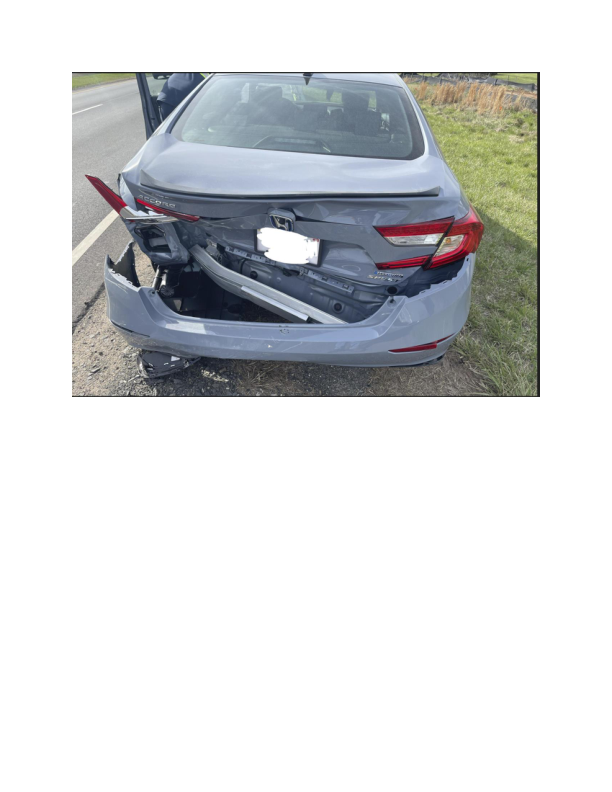

In [5]:
# Load an accident photo

vehicle_damage_file_path = os.path.join(
    data_dir, 'honda-major-damage.pdf'
)
policy_base64_image = pdf_page_to_base64(vehicle_damage_file_path,1)

display(IPImage(data=base64.b64decode(policy_base64_image)))

In [6]:
# Establish a Stateful class for agents to use

class ClaimState(TypedDict):
    claim_submitted: str
    claim_decision: str
    policy_number_on_record: str
    claim_number_on_record: str    
    delinquency_policyholder_status: str
    vehicle_damage_assessment_decision: str
    claim_payout: str
    claims_history: Annotated[list, operator.add]
    direct_deposit_payout_date: str
    claim_status: str
    claim_decision_letter: str
    markdown_claim_decision_letter: str
    claim_status_log: Annotated[list, operator.add]

In [7]:
# Define some module level variables (that will be overwritten for each trial)
POLICY_PDF = 'Allstate_honda_vehicle_insurance.pdf'
DAMAGE_PDF = 'honda-major-damage.pdf'
POLICY_DELINQUENT = 'random' # random will use 50/50, True will make policy delinquent, False will make policy current

In [8]:
# Define multi-agent nodes

def policyholder(state):
    # represents a policy (active or otherwise)
    return {"claim_status_log": ["policyholder submitted claim:"]} 

def policy_verification_agent(state):
    # Determine if the customer has a valid policy
    vehicle_insurance_file_path = os.path.join(
        data_dir, POLICY_PDF
    )
    policy_base64_image = pdf_page_to_base64(vehicle_insurance_file_path,1)
    llm = ChatOpenAI(model=model_name, temperature=0) 
    query = "What is the policy number"
    human_message = HumanMessage(
        content=[
            {"type": "text", "text": query},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{policy_base64_image}"},
            },
        ],
    )
    system_message = SystemMessage(content="You are a helpful assistant tasked with reviewing insurance policy document")
    policy_number_on_record = llm.invoke([system_message]+[human_message])
    policy_number_on_record_str = str(policy_number_on_record.content)
    policy_number_on_record = re.search(r"policy number is \*\*(.+?)\*\*", policy_number_on_record_str)
    if policy_number_on_record:
        policy_number = policy_number_on_record.group(1).strip()
        state['policy_number_on_record'] = policy_number
    else:
        state['policy_number_on_record'] = None

    # Check for dev's module level var for if policy is delinquent
    if POLICY_DELINQUENT is True:
        delinquency_policyholder_status = "Policyholder 90-Days Delinquent"
        state['claim_status_log'] = [state['claim_status_log'], delinquency_policyholder_status]        
    elif POLICY_DELINQUENT is False:
        delinquency_policyholder_status = "Current"
    # Here, let's just do a 50 / 50 (random sample) to simulate a delinquent policyholder
    elif random.random() > 0.5:
        # Simulate 50% probability a delinquent policyholder
        delinquency_policyholder_status = "Policyholder 90-Days Delinquent"
        state['claim_status_log'] = [state['claim_status_log'], delinquency_policyholder_status]
    else:
        delinquency_policyholder_status = "Current"

    return {"claim_status_log": ["policy_verification_agent"], "policy_number_on_record": policy_number, "delinquency_policyholder_status": delinquency_policyholder_status} 


def damage_assessment_agent(state):
    # Rank the level of damage
    vehicle_damage_file_path = os.path.join(
        data_dir, DAMAGE_PDF
    )
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 
    
    vehicle_damage_base64_image = pdf_page_to_base64(vehicle_damage_file_path,1)  
    query = "Classify the vehicle damage: no repair, minor repair, moderate repair, major repair, or irreparable?"
    message = HumanMessage(
        content=[
            {"type": "text", "text": query},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{vehicle_damage_base64_image}"},
            },
        ],
    )
    response = llm.invoke([message])    
    response_lower = response.content.lower()
    # Award a payout (random, for now!)
    if "no repair" in response_lower:
        vehicle_damage_assessment_decision = "No Repair"
        claim_payout = 0
    elif "minor repair" in response_lower:
        vehicle_damage_assessment_decision = "Minor Repair"
        claim_payout = random.uniform(100.0, 499.0)
    elif "moderate repair" in response_lower:
        vehicle_damage_assessment_decision = "Moderate Repair"
        claim_payout = random.uniform(500.0, 1999.0)
    elif "major repair" in response_lower:
        claim_payout = random.uniform(2000.0, 10000.0)
        vehicle_damage_assessment_decision = "Major Repair"
    elif "irreparable" in response_lower:
        claim_payout = random.uniform(15000.0, 35000.0)
        vehicle_damage_assessment_decision = "Irreparable"
    else:
        claim_payout = 0
        vehicle_damage_assessment_decision = "None"
    claim_payout_formatted = f"${claim_payout:.2f}"
    return {"claim_status_log": ["damage_assessment_agent"], 
            "vehicle_damage_assessment_decision": vehicle_damage_assessment_decision, 
            "claim_payout": claim_payout_formatted
           } 


def claim_processing_agent(state):
    # Get the current date
    current_date = datetime.date.today()
    # Format the date into a string (e.g., YYYY-MM-DD)
    formatted_date = current_date.strftime("%Y-%m-%d")
    # Create the formatted string
    claim_record = f"claim processed on date: {formatted_date}"
    return {"claim_status_log": ["claim_processing_agent"], "claims_history": [claim_record]} 


def claim_payment_agent(state):
    # 1. Get the current date
    current_date = datetime.date.today()
    # 2. Define a timedelta object for 7 days
    seven_days = datetime.timedelta(days=7)
    # 3. Add 7 days to the current date
    future_date = current_date + seven_days
    # 4. Format the future date into a string
    payout_date = future_date.strftime("%Y-%m-%d")
    # 5. Print the formatted string with the future date
    direct_deposit_payout_date = f"Direct deposit for the amount of the claim payout to the policyholder's checking account is scheduled for date: {payout_date}"
    return {"claim_status_log": ["claim_payment_agent"], "direct_deposit_payout_date": direct_deposit_payout_date} 


def claim_approved(state):
    formatted_letter = f"""We’re pleased to inform you that your claim has been processed and approved.\
    The payout will be directly deposited to your checking account within seven business days.\
    Thank you for choosing Allstate. If you have any questions, please contact us anytime.
    """
    return {"claim_status_log": ["claim_approved"], "claim_status": formatted_letter } 


def claim_denied(state):
    formatted_letter = f"""
    After careful review, we regret to inform you that your recent claim has been denied,\
    as it does not meet the coverage criteria outlined in your policy.\
    For more details or to discuss further, please contact our support team.
    """    
    
    return {"claim_status_log": ["claim_denied"], "claim_status": formatted_letter} 


def generate_claim_status(state):
    current_date = datetime.date.today()
    formatted_date = current_date.strftime("%Y-%m-%d")
    approved = 'claim_approved' in state['claim_status_log']

    formatted_letter = f"""
    Date: {formatted_date}
    policy_number_on_record: {state['policy_number_on_record']}
    Dear policyholder please review the decision reached by our team for your claim: {state['claim_submitted']}
    Claim Review Decision: {state['claim_status']}
    {state['claim_payout'] if approved else ''}
    Sincerely,\
    Allstate Claims Team"""    

    markdown_letter_instructions = f"""
    
    Use markdown formatting. 
    
    Create a document with markdown that has filled 3 sections: 
        - Date
        - Policy Number
        - Decision

    Use Allstate Insurance Claim Processing Departmentfor title of the letter (# markdown)
    Use Date for Date section header. (** markdown)
    Use Policy Number for Policy Number section header. (** markdown)
    Use Decision for Decision section header. (## markdown)


    Use the following text to generate the complete final insurance claim letter: {formatted_letter}"""
    
    message = HumanMessage(
        content=[
            {"type": "text", "text": markdown_letter_instructions},
        ],
    )

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 
    markdown_formatted_letter = llm.invoke([message])
    
    markdown_formatted_letter_str = markdown_formatted_letter.content
    
    return {"claim_status_log": ["generate_claim_status"], "claim_decision_letter": formatted_letter, "markdown_claim_decision_letter": markdown_formatted_letter_str, } 

In [9]:
# Construct the agents into a graph

# Add nodes
builder = StateGraph(ClaimState)

builder.add_node("policyholder", policyholder)
builder.add_node("policy_verification_agent", policy_verification_agent)
builder.add_node("damage_assessment_agent", damage_assessment_agent)
builder.add_node("claim_processing_agent", claim_processing_agent)
builder.add_node("claim_payment_agent", claim_payment_agent)
builder.add_node("claim_approved", claim_approved)
builder.add_node("claim_denied", claim_denied)
builder.add_node("generate_claim_status", generate_claim_status)

# Workflow
builder.add_edge(START, "policyholder")
builder.add_edge("policyholder", "policy_verification_agent")
builder.add_conditional_edges("policy_verification_agent", verify_policy)
builder.add_edge("damage_assessment_agent", "claim_payment_agent")
builder.add_edge("damage_assessment_agent", "claim_processing_agent")
builder.add_edge("claim_payment_agent", "claim_approved")
builder.add_edge("claim_processing_agent", "claim_approved")
builder.add_edge("claim_approved", "generate_claim_status")
builder.add_edge("claim_denied", "generate_claim_status")
builder.add_edge("generate_claim_status", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

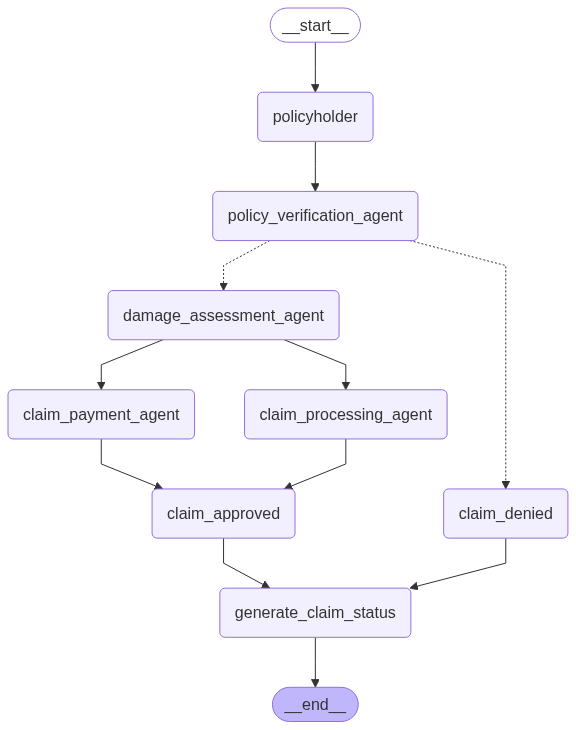

In [10]:
# View out graph, check for completness

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [11]:
# Create a function to instantiate the agent with a claim and policy

def process_claim(thread_id, claim_number, policy_number, damage_pdf_name):
    DAMAGE_PDF = damage_pdf_name
    config = {"configurable": {"thread_id": thread_id}}
    graph.invoke({"claim_submitted": [f"Claim number:{claim_number} and Policy number: {policy_number}"]}, config)
    final_state = graph.get_state(config)
    report = final_state.values.get('markdown_claim_decision_letter')
    return report

In [12]:
# Run the agent with a valid policy number and major damage
POLICY_DELINQUENT = False

report = process_claim(
    thread_id = "1",
    claim_number = '123',
    policy_number = '999 876 543',
    damage_pdf_name = 'honda-major-damage.pdf',
)
Markdown(report)

# Allstate Insurance Claim Processing Department

**Date**  
2025-05-17

**Policy Number**  
999 876 543

## Decision  
Dear policyholder, please review the decision reached by our team for your claim:  
**Claim number:** 123  
**Policy number:** 999 876 543  

Claim Review Decision: We’re pleased to inform you that your claim has been processed and approved. The payout of **$8419.44** will be directly deposited to your checking account within seven business days. Thank you for choosing Allstate. If you have any questions, please contact us anytime.

Sincerely,  
Allstate Claims Team

In [13]:
# Run with delinquent policy
POLICY_DELINQUENT = True

report = process_claim(
    thread_id = "2",
    claim_number = '123',
    policy_number = '999 876 543',
    damage_pdf_name = 'honda-major-damage.pdf',
)
Markdown(report)

# Allstate Insurance Claim Processing Department

**Date**  
2025-05-17

**Policy Number**  
999 876 543

## Decision  
Dear policyholder, please review the decision reached by our team for your claim:  
**Claim number:** 123  
**Policy number:** 999 876 543  

Claim Review Decision:  
After careful review, we regret to inform you that your recent claim has been denied, as it does not meet the coverage criteria outlined in your policy. For more details or to discuss further, please contact our support team.

Sincerely,  
Allstate Claims Team

In [14]:
# Run with an invalid policy number
POLICY_DELINQUENT = False

report = process_claim(
    thread_id = "3",
    claim_number = '123',
    policy_number = 'FOO BAR',
    damage_pdf_name = 'honda-major-damage.pdf',
)
Markdown(report)

# Allstate Insurance Claim Processing Department

**Date**  
2025-05-17

**Policy Number**  
999 876 543

## Decision  
Dear policyholder, please review the decision reached by our team for your claim:  
Claim number: 123 and Policy number: FOO BAR  

Claim Review Decision:  
After careful review, we regret to inform you that your recent claim has been denied, as it does not meet the coverage criteria outlined in your policy. For more details or to discuss further, please contact our support team.

Sincerely,  
Allstate Claims Team

In [15]:
# Run with minor damage

report = process_claim(
    thread_id = "4",
    claim_number = '123',
    policy_number = '999 876 543',
    damage_pdf_name = 'honda-minor-damage.pdf',
)
Markdown(report)

# Allstate Insurance Claim Processing Department

**Date**  
2025-05-17

**Policy Number**  
999 876 543

## Decision  
Dear policyholder, please review the decision reached by our team for your claim:  
**Claim number:** 123  
**Policy number:** 999 876 543  

Claim Review Decision: We’re pleased to inform you that your claim has been processed and approved. The payout of **$5,511.85** will be directly deposited to your checking account within seven business days. Thank you for choosing Allstate. If you have any questions, please contact us anytime.

Sincerely,  
Allstate Claims Team

In [16]:
# Run with moderate damage

report = process_claim(
    thread_id = "5",
    claim_number = '123',
    policy_number = '999 876 543',
    damage_pdf_name = 'honda-moderate-damage.pdf',
)
Markdown(report)

# Allstate Insurance Claim Processing Department

**Date**  
2025-05-17

**Policy Number**  
999 876 543

## Decision  
Dear policyholder, please review the decision reached by our team for your claim:  
**Claim number:** 123  
**Policy number:** 999 876 543  

Claim Review Decision: We’re pleased to inform you that your claim has been processed and approved. The payout of **$2605.29** will be directly deposited to your checking account within seven business days. Thank you for choosing Allstate. If you have any questions, please contact us anytime.

Sincerely,  
Allstate Claims Team